# STA 208: Homework 2 (Do not distribute)

## Due 05/08/2022 midnight (11:59pm)

__Instructions:__ 

1. Submit your homework using one file name ”LastName_FirstName_hw2.html” on canvas. 
2. The written portions can be either done in markdown and TeX in new cells or written by hand and scanned. Using TeX is strongly preferred. However, if you have scanned solutions for handwriting, you can submit a zip file. Please make sure your handwriting is clear and readable and your scanned files are displayed properly in your jupyter notebook. 
3. Your code should be readable; writing a piece of code should be compared to writing a page of a book. Adopt the one-statement-per-line rule. Consider splitting a lengthy statement into multiple lines to improve readability. (You will lose one point for each line that does not follow the one-statementper-line rule)
4. To help understand and maintain code, you should always add comments to explain your code. (homework with no comments will receive 0 points). For a very long comment, please break it into multiple lines.
5. In your Jupyter Notebook, put your answers in new cells after each exercise. You can make as many new cells as you like. Use code cells for code and Markdown cells for text.
6. Please make sure to print out the necessary results to avoid losing points. We should not run your code to figure out your answers. 
7. However, also make sure we are able to open this notebook and run everything here by running the cells in sequence; in case that the TA wants to check the details.
8. You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions


### Exercise 1 (Logistic regression)

(15 points) In class, we studied the logit model with 2 classes. Now consider the multilogit model with $K$ classes. Let $\beta$ be the $(p+1)(K-1)$-vector consisting of all the coefficients. Define a suitably enlarged version of the input vector x to accomodate this vectorized coefficient matrix. Derive the Newton-Raphson algorithm for maximizing the multinomial log-likelihood, and describe how you implement the algorithm (e.g., you can write a sudo code). 

__Solution__:

Based on the above assumption, we can define the following:
Let $x$ be the input vector, and $y$ be the output vector such that,
$$y_i \sim Multinomial(n = 1, p = \begin{bmatrix} p_1 \\ p_2 \\ \vdots \\ p_k \end{bmatrix})$$

We need to model the probability for the given data and the coefficients, what the log odds are going to be. Let $\beta$ be a $(p+1)(k-1)$ vector of all the coefficients. We need to model $p(X)$ such that, 

$$p(X) = \begin{bmatrix} p_1(x_i;\beta) \\ p_2(x_i;\beta) \\ \vdots \\ p_k(x_i;\beta) \end{bmatrix}$$

In a logistic regression setting, we model the log odds of the probability for a particular class as a linear regression. Let $k^{th}$ class be the reference class. We can model the log odds for the $1^{st}$ class as,

$$ \log \frac{p_1(x_i; \beta)}{p_k(x_i ; \beta)} = x_i^T \beta_1$$

Similarly, we can model the log odds for the $Z^th$ class ,such that $1 \leq Z \leq k-1$, as,

\begin{equation} 
\log \frac{p_Z(x_i; \beta)}{p_k(x_i; \beta)} = x_i^T \beta_Z
\end{equation}

Based on the above form, we can also conclude that,
$$ p_k(x_i; \beta) = 1 - \sum_{1 \leq j \leq k-1} p_j(x_i; \beta)$$

Using (1), we can define the ratio of the probability as,
$$
\frac{p_Z(x_i; \beta)}{1 - \sum_{1 \leq j \leq k-1} p_j(x_i; \beta)} = e^{x_i^T \beta_Z}
$$

Adding all probabilities from j = 1 ... k-1, we get,

$$
\begin{align*}
\frac{\sum_{1 \leq j \leq k -1 }p_j(x_i; \beta)}{1 - \sum_{1 \leq j \leq k -1 }p_j(x_i; \beta)} &= \sum_{1 \leq j \leq k -1 } e^{x_i^T \beta_Z} \\ 
1 - \sum_{1 \leq j \leq k -1 }p_j(x_i; \beta) &= \frac{1}{1 + \sum_{1 \leq j \leq k -1 } e^{x_i^T \beta_Z}} \\
\end{align*}
$$

Resubstituting the above equation, we get in the denominator, we get the probability of $j^{th}$ class as,
$$
p_j(x_i; \beta) = \frac{e^{x_i^T \beta_j}}{1 + \sum_{1 \leq Z \leq k -1 } e^{x_i^T \beta_Z}}
$$

Now, in order to estimate the coefficients, we need to find the likelihood of the data. Let $n$ be the number of samples. We can define the likelihood as,

$$
L(\beta) = \prod_{i=1}^{n}(\prod_{j=1}^{k} p_j(x_i; \beta)^{1_{(y_i = j)}})
$$

Taking the log likelihood, we get,
$$
l(\beta) = \sum_{i=1}^{n} (\sum_{l=1}^{k-1} y_l \beta_l x_i) + \log p_k(x_i; \beta)
$$

In order to find the estimates, we can use the Newton-Raphson algorithm. We define the beta at $t^th$ iteration as,

$$
\beta^{(t+1)} = \beta^{(t)} - (\frac{\partial^2 l(\beta)}{\partial \beta \partial \beta^T})^{-1} \frac{\partial l(\beta)}{\partial \beta}
$$

If $\beta$ is the vector of coefficients, and $x_i$ is the input vector, we can define the gradient as,

$$
\frac{\partial l(\beta)}{\partial \beta} = \begin{bmatrix} \frac{\partial l}{\partial \beta_1} \\
\vdots \\  \frac{\partial l}{\partial \beta_{k-1}} \end{bmatrix}
$$

Lets find the derivate wrt $\beta_l$,

$$
\begin{align*}
\frac{\partial l(\beta)}{\partial \beta_l} &= \sum_{i=1}^{n} (\sum_{l=1}^{k-1} y_{il} x_i - \frac{exp(\beta_l^T x_i)}{1 + \sum_{l=1}^{k-1} exp(\beta_l^T x_i)} x_i) \\
&= \sum_{i=1}^{n}y_{il}x_i - \sum_{i=1}^n P_l(x_i; \beta) x_i \\
&= X^T \begin{bmatrix} y_{1l} \\ \vdots \\ y_{nl} \end{bmatrix} - X^T \begin{bmatrix}P_l(x_1; \beta)\\ \vdots \\  P_l(x_n; \beta)\end{bmatrix}\\
&= X^T \begin{bmatrix} y_{1l} - P_1(x_1; \beta) \\ \vdots \\ y_{nl} - P_n(x_n; \beta) \end{bmatrix}
\end{align*}
$$

Similarly, we can find the double derivative as,
$$
\begin{align*}
\frac{\partial^2 l(\beta)}{\partial \beta_l \beta_l^{'T}} &= x_i e^{\beta_l^T x_i} x_i^T (1 + \sum_{i = 1}^{k-1}e^{\beta_l^Tx_i}) - (1 + \sum_{i = 1}^{k-1}e^{\beta_l^Tx_i})^{-2} x_i^T x_i \\
&= \begin{cases} -\sum_{i=1}^n p(y = l \mid X = x_i)(1 - p(y = l \mid X = x_i))x_i^Tx_i & \text{ when } l = l^{'} \\  -\sum_{i=1}^n p(y = l \mid X = x_i)(p(y = l^{'} \mid X = x_i))x_i^Tx_i & \text{ when } l \neq l^{'} \end{cases} \\
\end{align*}
$$

Once we have the double derivative, we can now form the hessian by gathering all the double derivatives in a matrix,
$$
\frac{\partial^2 l(\beta)}{\partial \beta_l \beta_l^{T}} = \begin{bmatrix} \frac{\partial^2 l}{\partial \beta_1 \beta_1^{T}} & \frac{\partial^2 l}{\partial \beta_1 \beta_2^{T}} & \cdots & \frac{\partial^2 l}{\partial \beta_1 \beta_{k-1}^{T}} \\ \vdots & \vdots & \ddots \\ \frac{\partial^2 l}{\partial \beta_{k-1} \beta_1^{T}} & \frac{\partial^2 l}{\partial \beta_{k-1} \beta_2^{T}} & \cdots & \frac{\partial^2 l}{\partial \beta_{k-1} \beta_{k-1}^{T}}\end{bmatrix} = X^T W X
$$

Hence, the new beta at $t^{th}$ iteration is,
$$
\begin{align*}
\beta^{(t+1)} &= \beta^{(t)} - (X^T W X)^{-1} \frac{\partial l(\beta)}{\partial \beta}\\
&= \beta^{(t)} - (X^T W X)^{-1} X^T \begin{bmatrix} y_{1l} - P_1(x_1; \beta) \\ \vdots \\ y_{nl} - P_n(x_n; \beta) \end{bmatrix}
\end{align*}
$$


### Exercise 2 (Support vector machine)

_Natural language processing_ (NLP) is a branch of artificial intelligence which gives computers the ability to learn text and spoken words in much the same way human beings can.

In python, text data can be converted into vector data through a vectorization operation.
Two vectorizer packages in Python are ``sklearn.feature_extraction.text.CountVectorizer`` and ``sklearn.feature_extraction.text.TfidfVectorizer``. A corpus is a collection of documents and the dictionary is all of the words in the corpus. A simple vectorizer will let $X_{i,j}$ be the number of times the $j$th word is in the $i$th document. 

Bag-of-words models is one of the most popular model in NLP. The model treats each document as a set of words but ignoring the order of those words. 

In this exercise, you will learn how to classify a text using SVM. The dataset includes two CSV files (`Corona_NLP_train.csv` and `Corona_NLP_test.csv`) that contain IDs and sentiment scores of the tweets related to the COVID-19 pandemic. The real-time Twitter feed is monitored for coronavirus-related tweets using 90+ different keywords and hashtags that are commonly used while referencing the pandemic. The oldest tweets in this dataset date back to October 01, 2019. 


The training dataset contains five columns: 
- UserName	
- ScreenName	
- Location	
- TweetAt	
- OriginalTweet	
- Sentiment (five labels: `extremely positive`, `positive`, `negative`, `extremely negative`, `neutral`)

The task is to predict sentiment basedon the original tweet. Here, we combine `extremely positive` and `positive` to `positive` and combine `extremely negative` and `negative` to `negative`. So, the sentiment contains three labels.
Your goal is to apply svm to predict the three labels based on OriginalTweet. Indeed, one can view this as a classification problem with three labels. 

I already attached the file `dataprocessing.ipynb` for processing the data. The code is directly copied from this [website](https://www.kaggle.com/code/mehmetlaudatekman/text-classification-svm-explained/notebook).

Please answer the following questions:
 


1. (15 points) Use sklearn svm.SVC on the TRAIN split (`Corona_NLP_train.csv`) and predict on the TEST split (`Corona_NLP_test.csv`). Plot your ROC and PR (Precision-Recall) curves for predicting `positive` (versus everything else); use the linear kernel and set the C parameter to be 1. Do the same for predicting the `negative` label versus everything else.  


__Solution__:

Preprocessing from the <code>dataprocessing.ipynb</code> file.

In [140]:
# Loading the libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import auc, roc_curve, PrecisionRecallDisplay, average_precision_score, precision_recall_curve
import re 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk 
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [141]:
# Loading the data
train_set = pd.read_csv('Corona_NLP_train.csv',encoding="latin1") # do not forget to change the path
test_set = pd.read_csv('Corona_NLP_test.csv',encoding="latin1")

# Dropping the unnecessary columns
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]
train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)

# split data based on sentiment values: positive, neutral or negative.
# Extremely positive is combined with positive. Similar to extremely negative
train_set["Sentiment"].value_counts()

# Handling the sentiment values
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]

negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]

neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]

import warnings as wrn
wrn.filterwarnings('ignore')

# Number coding the values
negatives["Sentiment"] = 0 
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

# Combining the data together
data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [142]:
# Getting a preview into the dataset
data.head()

,index,OriginalTweet,Sentiment
0,1,advice Talk to your neighbours family to excha...,2
1,2,Coronavirus Australia: Woolworths to give elde...,2
2,3,My food stock is not the only one which is emp...,2
3,5,As news of the regionÂs first confirmed COVID...,2
4,6,Cashier at grocery store was sharing his insig...,2


In [143]:
# Cleanning the words in the tweets
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

# Vectorising the tweets    
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)


In [144]:
# Splitting the data into training and testing sets
y = label_binarize(np.asarray(data["Sentiment"]), classes=[0,1,2])
x_train,x_test,y_train,y_test = train_test_split(BOW,y)

In [145]:
# Fitting the SVM Model
svm_model = OneVsRestClassifier(LinearSVC(C = 1, loss = 'hinge'))

In [146]:
# Training the dataset
svm_model.fit(x_train,y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1, loss='hinge'))

In [147]:
y_score = svm_model.decision_function(x_test)

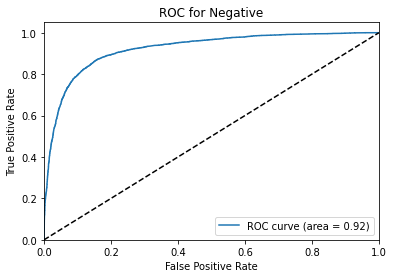

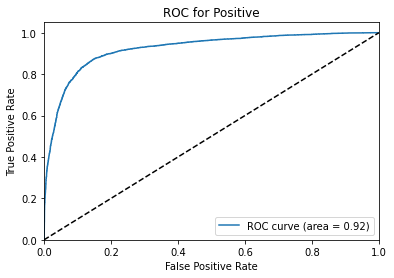

In [148]:
# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # Compute ROC curve and ROC area for each class
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i,label in zip([0,2],["Negative","Positive"]):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(label))
    plt.legend(loc="lower right")
    plt.show()

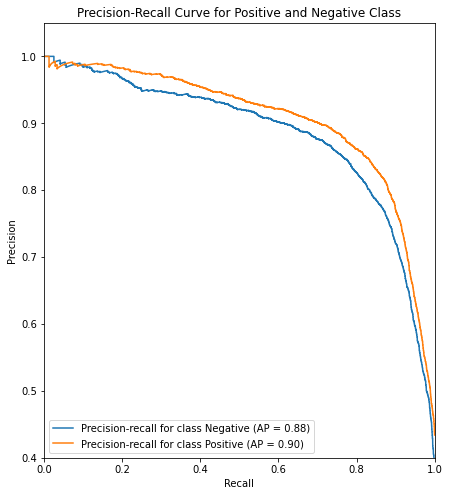

In [149]:
# Compute Precision-Recall curve
precision = dict()
recall = dict()
average_precision = dict()
from itertools import cycle

# Setting the plot up for the Precision-Recall curve
_, ax = plt.subplots(figsize=(7, 8))

# Getting the values of PR curve for each class 
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Generating plots for the Precision-Recall curve
for i, label in zip([0,2],["Negative","Positive"]):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {label}")
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.4, 1.05])
ax.set_title("Precision-Recall Curve for Positive and Negative Class")
plt.show()

2. (10 points) In this problem, we have three labels (instead of two). In class, we only learned SVM for solving a two-class classification problem. Describe (using your own words) how the python package `svm.SVC` fits SVM for multi-class classification.

__Solution__: 

For a classification problem, the SVM is a binary classifier. In this problem, we have three labels. So, the SVM is a multi-class classifier which is used by breaking down the multi-class problem into three binary problems.

The idea is that one can use One-to-Rest approach. In that approach, the breakdown is set to a binary classifier per each class.

A single SVM does binary classification and can differentiate between two classes. So that, according to the two breakdown approaches, to classify data points from m classes data set: In the One-to-Rest approach, the classifier can use $\pmb{m}$ SVMs. Each SVM would predict membership in one of the $\pmb{m}$ classes. In python, we use the OneVsRestClassifier wrapper on top of the SVM.

3. (10 points) Choose several different values (between 3 and 8) for C (some smaller than 1, some bigger than 1), plot the ROC curves for predicting 'positive' (versus everything else), and predicting 'negative' (versus everything else). Comment on your findings. 

__Solution__:

In [150]:
# Generating random values for C
# We generate 4 random values for C between 0 and 1 and 4 random values for C between 1 and 100
np.random.seed(2022)
# C values between 0 and 1
C_vals = np.random.uniform(0.1,1,4)
# C values between 1 and 100
C_vals_other = np.random.uniform(1,100,4)
# Combining the two lists
C_vals = np.sort(np.concatenate((C_vals,C_vals_other)))

In [151]:
# Storing data for each C value
C_data = dict()
for c in C_vals:
    # Fitting the SVM model
    svm_model = OneVsRestClassifier(LinearSVC(C = c, loss = 'hinge'))
    svm_model.fit(x_train,y_train)
    y_score = svm_model.decision_function(x_test)
    
    # Compute ROC curve and ROC area for each class
    n_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Storing the data for each C value
    C_data[c] = {} 
    C_data[c]["fpr"] = fpr
    C_data[c]["tpr"] = tpr
    C_data[c]["roc_auc"] = roc_auc

<Figure size 432x288 with 0 Axes>

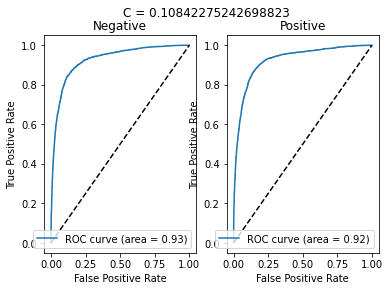

<Figure size 432x288 with 0 Axes>

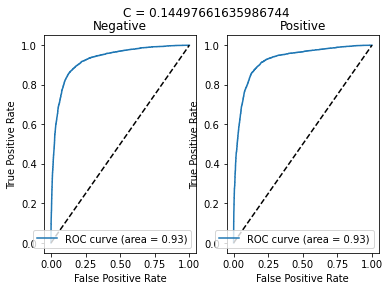

<Figure size 432x288 with 0 Axes>

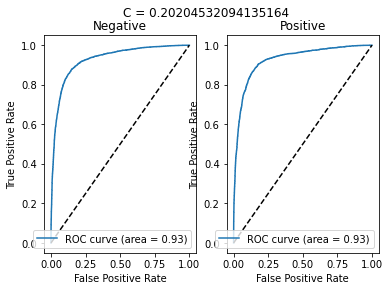

<Figure size 432x288 with 0 Axes>

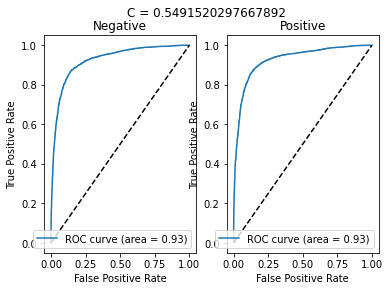

<Figure size 432x288 with 0 Axes>

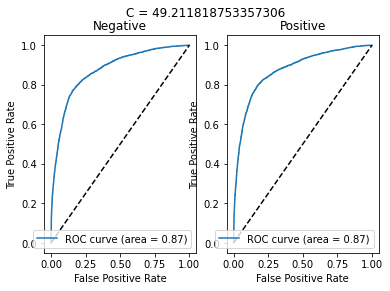

<Figure size 432x288 with 0 Axes>

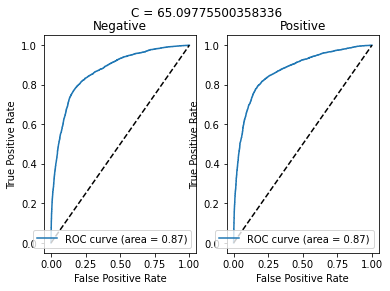

<Figure size 432x288 with 0 Axes>

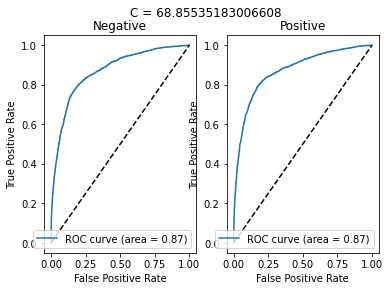

<Figure size 432x288 with 0 Axes>

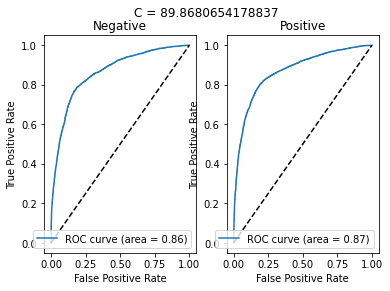

In [152]:
# Generating plots for the ROC curve for positive and negative class for each C value
for c,data in C_data.items():
    plt.figure()
    fig,(ax1,ax2) = plt.subplots(1,2)
    # PLot for positive class
    ax1.plot(data["fpr"][0], data["tpr"][0], label='ROC curve (area = %0.2f)' % data["roc_auc"][0])
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title("Negative")
        
    # Plot for negative class
    ax2.plot(data["fpr"][2], data["tpr"][2], label='ROC curve (area = %0.2f)' % data["roc_auc"][2])
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title("Positive")
    
    fig.suptitle('C = {}'.format(c))
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
    plt.show()

With a higher value of C, the optimization will choose a smaller margin hyperplane if that hyper plane does a decent job in classifying the points correctly. Hence with a larger value of C, the number of missclassified points will be reduced. Conversely, with a smaller value of C, the number of missclassified points will be increased.

4. (Bonus 10 points) Explore how to use logistic regression to classify this text. Implement the method. Comment on its prediction accuracy and compare the ROC curve with the SVM ROC curve. 

__Note:__ the PR curve is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class.

__Solution__:

In [153]:
# Importing the libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

# Getting the orginal y back 
# y_train = y_train.dot([0,1,2])

# Fitting the logistic regression model with multiple classes one vs rest classifier
lr = OneVsRestClassifier(LogisticRegression(C=1.0))
lr.fit(x_train,y_train)


OneVsRestClassifier(estimator=LogisticRegression())

In [158]:

# Getting the predicted y
y_pred = lr.decision_function(x_test)
y_pred 


array([[-1.767354  ,  0.2190565 , -0.87645757],
       [-1.45158643,  1.12150345, -1.36472833],
       [-4.40092571, -1.08520926,  1.59790543],
       ...,
       [-4.37066642, -6.11795753,  4.55664505],
       [-3.43687278, -3.65922262,  2.65454662],
       [ 5.73287123, -3.99667882, -7.36483477]])

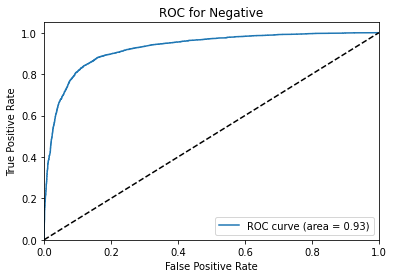

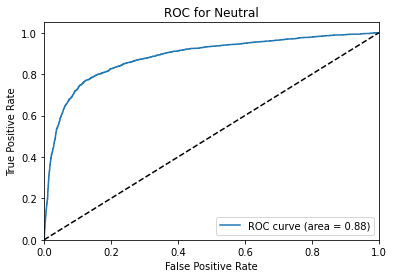

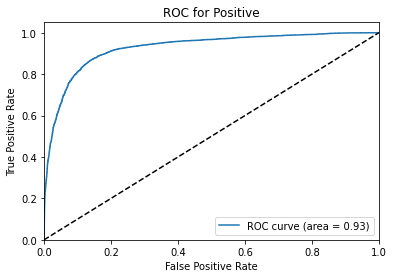

In [157]:
# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i,label in zip([0,1,2],["Negative","Neutral","Positive"]):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(label))
    plt.legend(loc="lower right")
    plt.show()

The ROC curve seems similar in both cases, in case of SVM and logistic regression.

### Exercise 3 (K-means and PCA)

Load the poses.csv dataset, which is a concatenation of other datasets to form a larger dataset. The task column in the dataset contains six poses: sitting, lying, walking, standing, cycling, bending. I want you to act like the dataset is from the same experiment. You need to open the file and take a look the dataset first. Combining bending1 and bending2 together. 


1. (15 pts) Apply 1 time lag difference of the dataset, so that each variable is the difference of the time point and the previous time point.  Standardize the dataset and remove any variables that do not make sense.  Run the PCA decomposition with 2 principal components.  Plot the 2 principal components.  Which variables have the most loading on the principal components (look at `.components_`)?

__Solution__:

In [101]:
# Importing the required libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [116]:
# Loading the dataset
df = pd.read_csv("poses.csv")
# Dropping the values
df = df.drop(["Unnamed: 0"],axis=1)

# Looking at the columns and rechanging into better understandable names
df.columns = ['Time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
       'avg_rss23', 'var_rss23', 'task','filename']

df.head()

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,task,filename
0,0,42.00,0.00,11.50,4.56,18.50,0.87,sitting,dataset14.csv
1,250,41.75,0.43,21.50,1.80,11.75,1.48,sitting,dataset14.csv
2,500,41.67,0.47,9.33,5.44,12.00,2.83,sitting,dataset14.csv
3,750,40.00,0.82,12.67,0.94,17.75,1.09,sitting,dataset14.csv
4,1000,40.25,0.83,12.25,0.43,18.25,0.43,sitting,dataset14.csv


In [117]:
# It seems like the data is misformatted when the task is bending2 and the dataset4 is not properly formatted
vals_misinformed = df.index[(df["filename"] == "dataset4.csv") & (df["task"] == "bending2")].tolist()
def format_bending_2(x):
    # Splitting the data on comma and returning it as a series
    vals = x["Time"].split(" ")
    return pd.Series(vals[:-1])

# Formatting the data for dataset4
df.iloc[vals_misinformed,0:7] = df.loc[vals_misinformed].apply(format_bending_2,1)

In [118]:
# Droping the filename column since it is not needed anymore
df = df.drop(["filename"],axis=1)

In [119]:
# Combining the data for class bending 1 and bending 2
def combine_bending(x):
    # Check if class is bending 1 or 2 and return bending 
    if x == "bending1" or x == "bending2":
        return "bending"
    
    return x

# Applying the function to the task column
df["task"] = df["task"].apply(combine_bending)

In [120]:
# CHhanging the data type to the most appropriate one
df["task"] = df["task"].astype("category")
df["Time"] = df["Time"].astype("float64")

In [130]:
# Extracting predictor and target variables
variables = ["avg_rss12","avg_rss13","avg_rss23","var_rss12","var_rss13","var_rss23"]
df[variables] = df[variables].astype("float64")
for i in variables:
    df.loc[:,i] = df[i] - df.groupby("task")[i].shift(1)

In [131]:
df.isna().sum()
df = df.dropna()

In [132]:
X = df[variables]
y = df["task"]

In [133]:
# Standardizing the data using StandardScaler
scalar = StandardScaler()
# Fitting and transforming the data
X = scalar.fit_transform(X)

In [134]:
# Fitting the PCA with 2 components
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

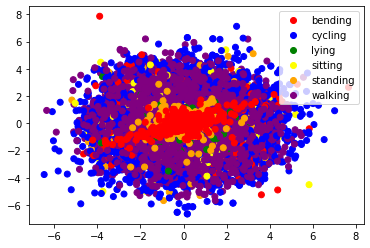

In [135]:
# Getting a scatter plot based on the transformed data
colors = ['red', 'blue', 'green','yellow','orange','purple']
labels = np.unique(y)

color_map = dict(zip(labels,colors))

plt.scatter(X_transformed[:,0], X_transformed[:,1],c = [color_map[i] for i in y])
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
plt.legend(markers,color_map.keys(), numpoints = 1)
plt.show()

In [137]:
# Loading matrix
pca.components_.T * np.sqrt(pca.explained_variance_)

array([[-0.15534192,  0.10543502],
       [ 0.7136058 ,  0.36324384],
       [ 0.37072073, -0.72352194],
       [-0.27975268, -0.10296051],
       [-0.70712649, -0.34992196],
       [-0.34965908,  0.71742   ]])

In [138]:
pca.explained_variance_

array([1.37134911, 1.31428433])


2. (15 pts) Also on the 1 lagged dataset.  Run K-means clustering (with 6 clusters), how much does the cluster overlap with the 'task' variable.  Look at the confusion matrix (`sklearn.metrics.confusion_matrix`) of the cluster against the 'task'.  Is there a clear mapping from clusters to task?

__Solution__:

In [159]:
# Fitting a KMeans model with 6 clusters
kmeans_model = KMeans(n_clusters=6, random_state=0).fit(X_transformed)

In [162]:
# Storing the predictors in a dataframe
new_df = pd.DataFrame(X_transformed)
new_df["cluster"] = kmeans_model.labels_

# Dropping any missing values
new_df = new_df.dropna()

In [93]:
# Converting numerical values to categorical
cluster_label = {
    0: "bending",
    1: "cycling",
    2: "lying",
    3: "sitting",
    4: "standing",
    5: "walking"
}

<AxesSubplot:xlabel='0', ylabel='1'>

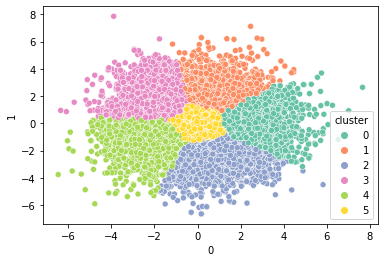

In [176]:
import seaborn as sns
sns.scatterplot(new_df.loc[:,0], new_df.loc[:,1], hue=new_df["cluster"], palette = "Set2")

In [180]:
cm = confusion_matrix(y,new_df["cluster"])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap = "Oranges")

ValueError: Found input variables with inconsistent numbers of samples: [44955, 42227]